In this short post, we will explore a problem recently submitted to me by one of my roommates, and an approximate solution to this problem.

The problem is as follows: given a set of $n$ points, can you find $k$ points among them that are chosen such that they are farthest apart from each other? 

This is a very general problem, to which a short search I did not find any "optimal" or classical solution, although there must exist some. Instead, we will implement the algorithm that my roommate has come up with to find an approximate solution.

We will follow the advice of Peter Norvig (from his wonderful post on the [travelling salesman problem](http://nbviewer.ipython.org/url/norvig.com/ipython/TSPv3.ipynb)):

>In general our design philosophy is to first write an English description of the algorithm, then write Python code that closely mirrors the English description. This will probably require some auxilliary functions and data structures; just assume they exist; put them on a TO DO list, and eventually define them with the same design philosophy.

We will consider the problem in the frame of points in the 2D plane and found in the range $[-1, 1]^2$. We will represent these points using the complex number type available in Python (inspired by Peter Norvig).

Our first requirement will be to plot a list of points. We can write the following function for this.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def plot_points(points, ax=None, style={'marker': 'o', 'color':'b'}, label=False):
    """plots a set of points, with optional arguments for axes and style"""
    if ax==None:
        ax = plt.gca()
    for ind, p in enumerate(points):
        ax.plot(p.real, p.imag, **style)
        if label:
            ax.text(p.real, p.imag, s=ind, horizontalalignment='center', verticalalignment='center')
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)

We will examine two types of datasets:

- points distributed on a unit circle
- points distributed randomly in the [-1, 1]^2 interval

We write functions for both datasets below:

In [3]:
import math
import random

In [4]:
def create_circle_points(n):
    """creates a list of n points on a circle of radius one"""
    return [math.cos(2 * math.pi * i / float(n)) + \
            1j * math.sin(2 * math.pi * i / float(n)) for i in range(n)]

In [5]:
def create_point_cloud(n):
    return [2 * random.random() - 1 + 1j * (2 * random.random() - 1) for _ in range(n)]

Let's test these two datasets with our plotting function:

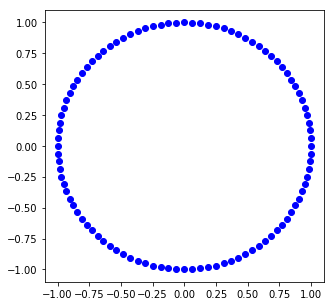

In [6]:
fig = plt.figure(figsize=(5, 5))
circle100 = create_circle_points(100)
plot_points(circle100)

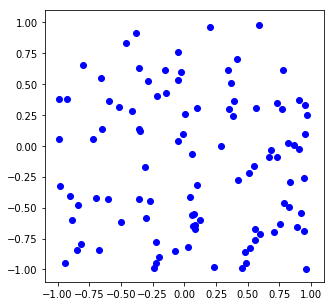

In [7]:
fig = plt.figure(figsize=(5, 5))
cloud100 = create_point_cloud(100)
plot_points(cloud100)

Now, we will turn to our problem: can we find $k$ points that are as far possible apart from each other?

Our approximate algorithm will work as follows:

- choose one point at random as a starting point
- add the farthest point from the remaining points to the solution set
- do this until we have reached $k$ points in the solution set

In [8]:
def incremental_farthest_search(points, k):
    remaining_points = points[:]
    solution_set = []
    solution_set.append(remaining_points.pop(\
                                             random.randint(0, len(remaining_points) - 1)))
    for _ in range(k-1):
        distances = [distance(p, solution_set[0]) for p in remaining_points]
        for i, p in enumerate(remaining_points):
            for j, s in enumerate(solution_set):
                distances[i] = min(distances[i], distance(p, s))
        solution_set.append(remaining_points.pop(distances.index(max(distances))))
    return solution_set

#TODO: function distance

We now define a distance function (the absolute value of the difference of two complex numbers returns the distance between them).

In [9]:
def distance(A, B):
    return abs(A - B)

Now, let's run the algorithm:

In [10]:
incremental_farthest_search(circle100, 2)

[(-0.30901699437494756-0.9510565162951535j),
 (0.30901699437494745+0.9510565162951535j)]

Let's plot the result of the algorithm.

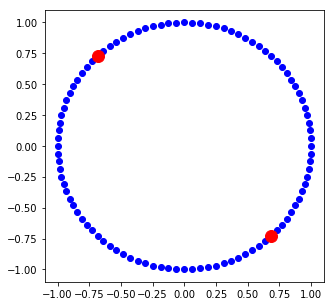

In [11]:
fig = plt.figure(figsize=(5, 5))
plot_points(circle100)
plot_points(incremental_farthest_search(circle100, 2), style={'marker': 'o', 'color':'r', 'markersize': 12})

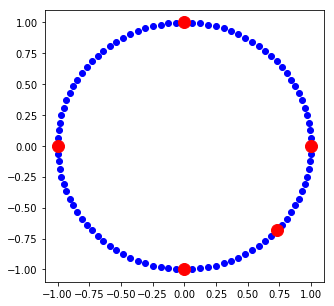

In [12]:
fig = plt.figure(figsize=(5, 5))
plot_points(circle100)
plot_points(incremental_farthest_search(circle100, 5), style={'marker': 'o', 'color':'r', 'markersize': 12})

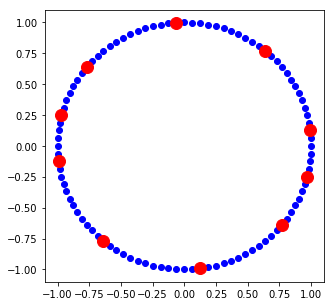

In [13]:
fig = plt.figure(figsize=(5, 5))
plot_points(circle100)
plot_points(incremental_farthest_search(circle100, 10), style={'marker': 'o', 'color':'r', 'markersize': 12})

Due to the random initialization, this will return different solutions to the problem if we run it multiple times.

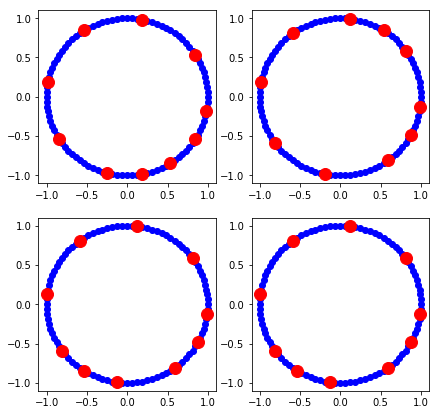

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
for ax in axes.ravel():
    plot_points(circle100, ax=ax)
    plot_points(incremental_farthest_search(circle100, 10), 
                ax=ax, 
                style={'marker': 'o', 'color':'r', 'markersize': 12})

How does this extend to a point cloud?

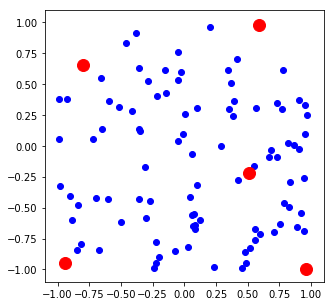

In [15]:
fig = plt.figure(figsize=(5, 5))
plot_points(cloud100)
plot_points(incremental_farthest_search(cloud100, 5), style={'marker': 'o', 'color':'r', 'markersize': 12})

Again, we can see how this compares when we do it multiple times:

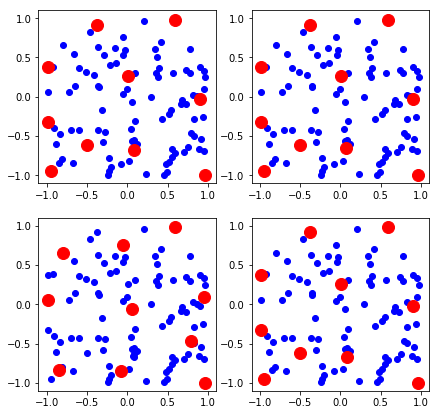

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
for ax in axes.ravel():
    plot_points(cloud100, ax=ax)
    plot_points(incremental_farthest_search(cloud100, 10), 
                ax=ax, 
                style={'marker': 'o', 'color':'r', 'markersize': 12})

In fact, we can compare the different solutions using an animation. Since version 2.1, `matplotlib` includes [support for javascript based frame-by-frame animations](http://matplotlib.org/users/whats_new.html#interactive-js-widgets-for-animation).

In [17]:
from IPython.display import HTML
import matplotlib.animation as mpl_anim

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))

def init():
    return

def animate(i):
    ax.cla()
    plot_points(cloud100, ax=ax)
    plot_points(incremental_farthest_search(cloud100, 5), 
                ax=ax, 
                style={'marker': 'o', 'color':'r', 'markersize': 12})

animation = mpl_anim.FuncAnimation(fig, animate, init_func=init,
                        frames=10, interval=100, blit=False)
plt.close(fig)
HTML(animation.to_jshtml())

Based on the previous implementation, we can define a criterion to distinguish between solutions and find the best among a given set of solutions. We choose the sum of the distances between the candidate solutions.

In [19]:
def evaluate_solution(solution_set):
    return sum([distance(a, b) for a, b in zip(solution_set[:-1], solution_set[1:])])

In the case of the circle, the optimal solution can be shown to be $n-1$ times the distance between two points rotated by $2 \pi \over n$ (in particular we pick the point with coordinates $(1, 0)$ and its rotated version):

$$
d_{opt} = (n-1) \sqrt{(\cos{\frac{2\pi}{n}} - 1)^2 + (\sin{\frac{2\pi}{n}})^2}
$$

In [20]:
def optimal_circle_solution(n):
    return (n-1) * math.sqrt((math.cos(2 * math.pi / n) - 1)**2 + \
                         math.sin(2 * math.pi / n)**2)

We can check that the solution is correct for test cases 2 and 4, since they are easy.

Here's test case 2 points on a circle. 

In [21]:
optimal_circle_solution(2)

2.0

2.0

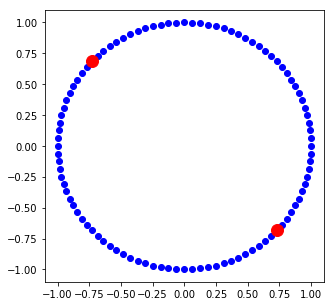

In [22]:
fig = plt.figure(figsize=(5, 5))
plot_points(circle100)
sol = incremental_farthest_search(circle100, 2)
plot_points(sol, style={'marker': 'o', 'color':'r', 'markersize': 12})
evaluate_solution(sol)

And here's test case 4 points on a circle.

In [23]:
optimal_circle_solution(4)

4.242640687119285

5.414213562373095

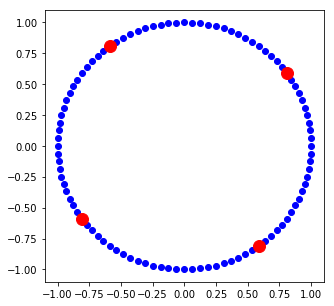

In [24]:
fig = plt.figure(figsize=(5, 5))
plot_points(circle100)
sol = incremental_farthest_search(circle100, 4)
plot_points(sol, style={'marker': 'o', 'color':'r', 'markersize': 12})
evaluate_solution(sol)

Here we see that our approximate algorithm does not yield the right answer. To see why, we plot the point labels, their order in the solution set.

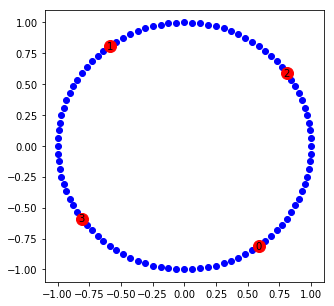

In [25]:
fig = plt.figure(figsize=(5, 5))
plot_points(circle100)
plot_points(sol, style={'marker': 'o', 'color':'r', 'markersize': 12}, label=True)

As we see, the points don't have the expected order, thus computing the sum of the distances between points does not yield the minimal and optimal solution. However, we can compute this by hand to make sure the result is correct:

In [26]:
distance(sol[2], sol[0]) + distance(sol[0], sol[3]) + distance(sol[3], sol[1])

4.242640687119286

This is the expected value. So our "farthest neighbours approximate algorithm" behaves as we expect it on these two test cases.

What about another larger test case, 10?

In [27]:
optimal_circle_solution(10)

5.562305898749053

14.693153625647701

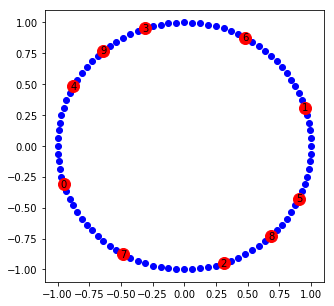

In [28]:
fig = plt.figure(figsize=(5, 5))
plot_points(circle100)
sol = incremental_farthest_search(circle100, 10)
plot_points(sol, style={'marker': 'o', 'color':'r', 'markersize': 12}, label=True)
evaluate_solution(sol)

This is not very satisfying. Also, the metric we use suffers again from the permutation problem highlighted in the case of test case 4.

We can define a better solution by running the algorithm several times and keeping the one that minimizes the criterion above:

In [29]:
def best_solution(points, k, tries):
    solution_sets = [incremental_farthest_search(points, k) for _ in range(tries)]
    sorted_solutions = sorted(solution_sets, key=evaluate_solution, reverse=False)
    return sorted_solutions[0]

12.18068388836029

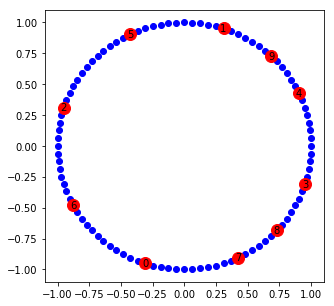

In [30]:
fig = plt.figure(figsize=(5, 5))
plot_points(circle100)
sol = best_solution(circle100, 10, 100)
plot_points(sol,
           style={'marker': 'o', 'color':'r', 'markersize': 12}, label=True)
evaluate_solution(sol)

Unfortunately, this does not eliminate the ordering problem that is important when computing the metric. As a quick workaround, we could order the points by their angle:

In [31]:
sorted_sol = sorted(sol, key=lambda p: math.atan2(p.imag, p.real))

5.361390426676054

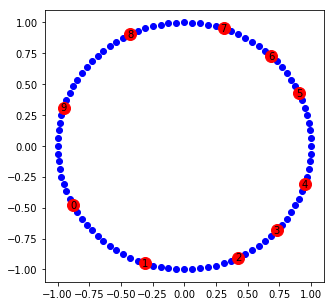

In [32]:
fig = plt.figure(figsize=(5, 5))
plot_points(circle100)
plot_points(sorted_sol,
           style={'marker': 'o', 'color':'r', 'markersize': 12}, label=True)
evaluate_solution(sorted_sol)

This is closer to the optimal solution. Actually, it is even lower. This is due to the fact that our metric does not take into account the last segment "closing the circle".

Let's finish this with an animation of different solutions for growing number of points on the circle and then on the random point cloud.

In [33]:
fig, ax = plt.subplots(figsize=(5, 5))

def init():
    return

def animate(i):
    ax.cla()
    plot_points(circle100, ax=ax)
    plot_points(incremental_farthest_search(circle100, i+1), 
                ax=ax, 
                style={'marker': 'o', 'color':'r', 'markersize': 12})
    ax.set_title(f"{i+1} points")

animation = mpl_anim.FuncAnimation(fig, animate, init_func=init,
                        frames=20, blit=False)
plt.close(fig)
HTML(animation.to_jshtml())

In [34]:
fig, ax = plt.subplots(figsize=(5, 5))

def init():
    return

def animate(i):
    ax.cla()
    plot_points(cloud100, ax=ax)
    plot_points(incremental_farthest_search(cloud100, i+1), 
                ax=ax, 
                style={'marker': 'o', 'color':'r', 'markersize': 12})
    ax.set_title(f"{i+1} points")

animation = mpl_anim.FuncAnimation(fig, animate, init_func=init,
                        frames=20, blit=False)
plt.close(fig)
HTML(animation.to_jshtml())

Let's end this post here and review a few things. 


We explored an approximate solution to the farthest neighbors problem and tried to compare our expectations with the algorithm outputs on test cases. As far as I can tell, the algorithm does what it is supposed to do. However, it's far from perfect. And we couldn't compare its results to "true solutions" since this problem explodes in terms of combinatorial optimization, just like the [travelling salesman problem](https://github.com/norvig/pytudes/blob/master/ipynb/TSP.ipynb).

Regarding the studied applications, I believe this algorithm behaves quite well for point clouds, but we can observe that for circle patterns, the solution will not be optimal since the greedily chosen points hinder the formation of well-space points on the circle.

This post was entirely written using the IPython notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20150716_FarthestNeighbors.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20150716_FarthestNeighbors.ipynb).